# Quick start

Let's set up a simple emulator for scattering of 14.1 MeV protons on $^{27}$Al, using the [Koning-Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw) optical potential for the proton-nucleus interaction.

In [1]:
import rose
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# set up kinematics
from rose.koning_delaroche import KDGlobal, Projectile

# for 27-Al
A = 27
Z = 13

# lab bombarding energy
Elab = 14.1  # MeV

# get kinematics and default KD params
omp = rose.koning_delaroche.KDGlobal(Projectile.proton)
(mu, Ecom, k, eta, R_C), parameters = omp.get_params(A, Z, Elab)

In [3]:
# take train and test parameter samples from a box bounded
# 50% above and below the default values
scale = 0.5

bounds = np.array(
    [
        parameters - np.fabs(scale * parameters),
        parameters + np.fabs(scale * parameters),
    ]
).T

In [4]:
from rose.training import sample_params_LHC

# sample points for a train/test split
# sample from +/-50% around the default params using Latin hypercube
n_test = 10
n_train = 90
train = sample_params_LHC(n_train, parameters, scale, seed=13)
test = sample_params_LHC(n_test, parameters, scale, seed=721)

Instantiate the set of interactions for each partial wave. We use the type `InteractionEIMSpace` because we will use the Empirical Interpolation Method (EIM) to handle potentials that are non-affine (like the Woods-Saxon forms in Koning-Delaroche). For more detail, see the following tutorials.

In [5]:
interactions = rose.InteractionEIMSpace(
    rose.koning_delaroche.KD_simple,
    len(parameters),
    mu,
    Ecom,
    is_complex=True,
    spin_orbit_potential=rose.koning_delaroche.KD_simple_so,
    training_info=bounds,
    Z_1=1,
    Z_2=13,
    R_C=R_C,
)

Now that we have our `InteractionSpace` set up, we can construct a `ScatteringAmplitudeEmulator`, which trains and runs the emulator for us.

In [6]:
# set up and train emulator using sensible defaults
emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    train,
    n_basis=10,  # we will just choose 10 out of a hat for now, more on this later
    angles=np.linspace(np.pi / 181, np.pi, 180),
    l_cutoff_rel=1e-6,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:52<00:00,  5.34s/it]


It's as simple as that, now we have a trained emulator we can use to calculate cross sectons! Let's compare observables between the emulator and the high-fidelity solver using our test set of sampled parameters. We will do this by calling the functions `emulate_xs` and `exact_xs` on our emulator, passing in a set of parameters from our test set.

In [7]:
%%time
# use %%timeit to get a more percise timing  - but may take a while to run!

# run high-fidelity solver
HIFI_xs = []
for sample in tqdm(test):
    HIFI_xs.append(emulator.exact_xs(sample))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.53s/it]

CPU times: user 2min 45s, sys: 828 ms, total: 2min 46s
Wall time: 2min 45s


In [8]:
%%time
# use %%timeit to get a more percise timing  - this one will be fast either way!

# run emulator
emu_xs = []
for sample in tqdm(test):
    emu_xs.append(emulator.emulate_xs(sample))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.11it/s]

CPU times: user 322 ms, sys: 554 ms, total: 876 ms
Wall time: 149 ms


Now let's plot the results!

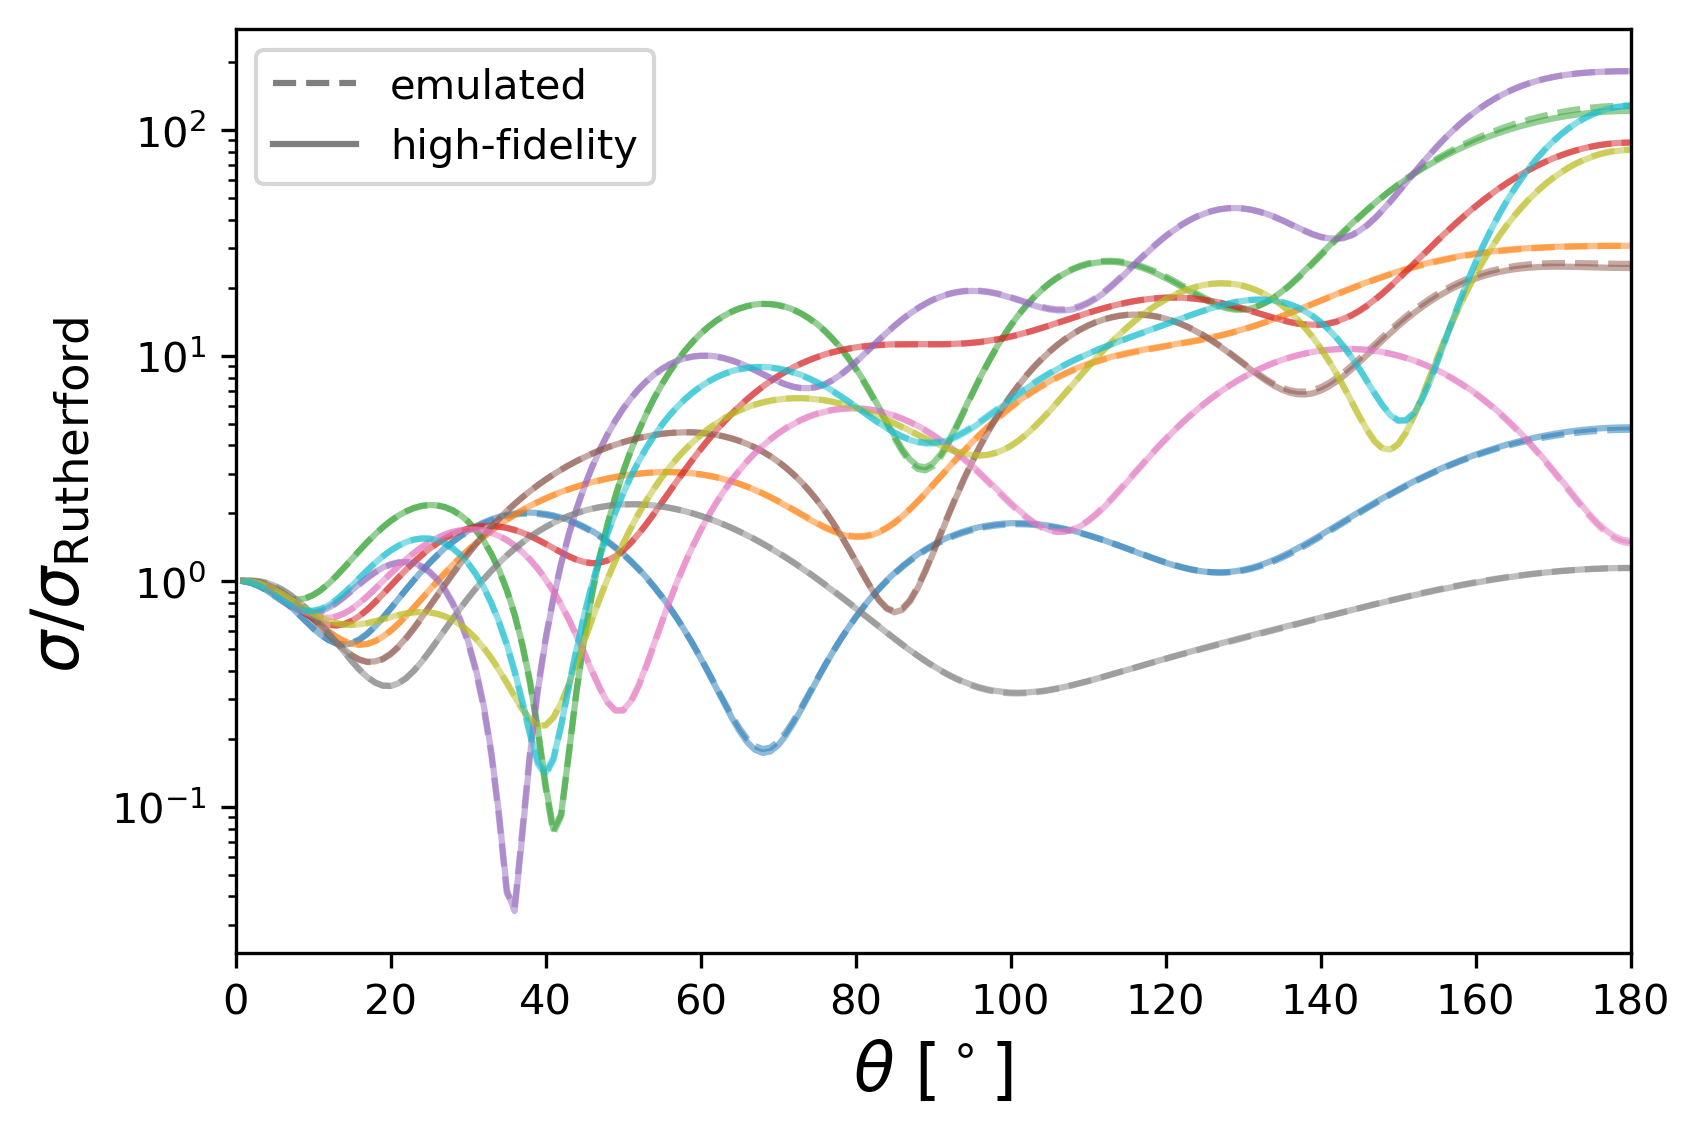

In [9]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test):
    x = emulator.angles * 180 / (np.pi)

    # HIFI
    y_exact = HIFI_xs[i].dsdo

    # emulated
    y_emu = emu_xs[i].dsdo

    p = ax.plot(x, y_emu, "--", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=16)
plt.ylabel(r"$\frac{d \sigma}{d\Omega}$ [mb/Sr]", fontsize=16)

plt.ylabel(r"$\sigma / \sigma_{\rm{Rutherford}}$ ", fontsize=16)
plt.show()

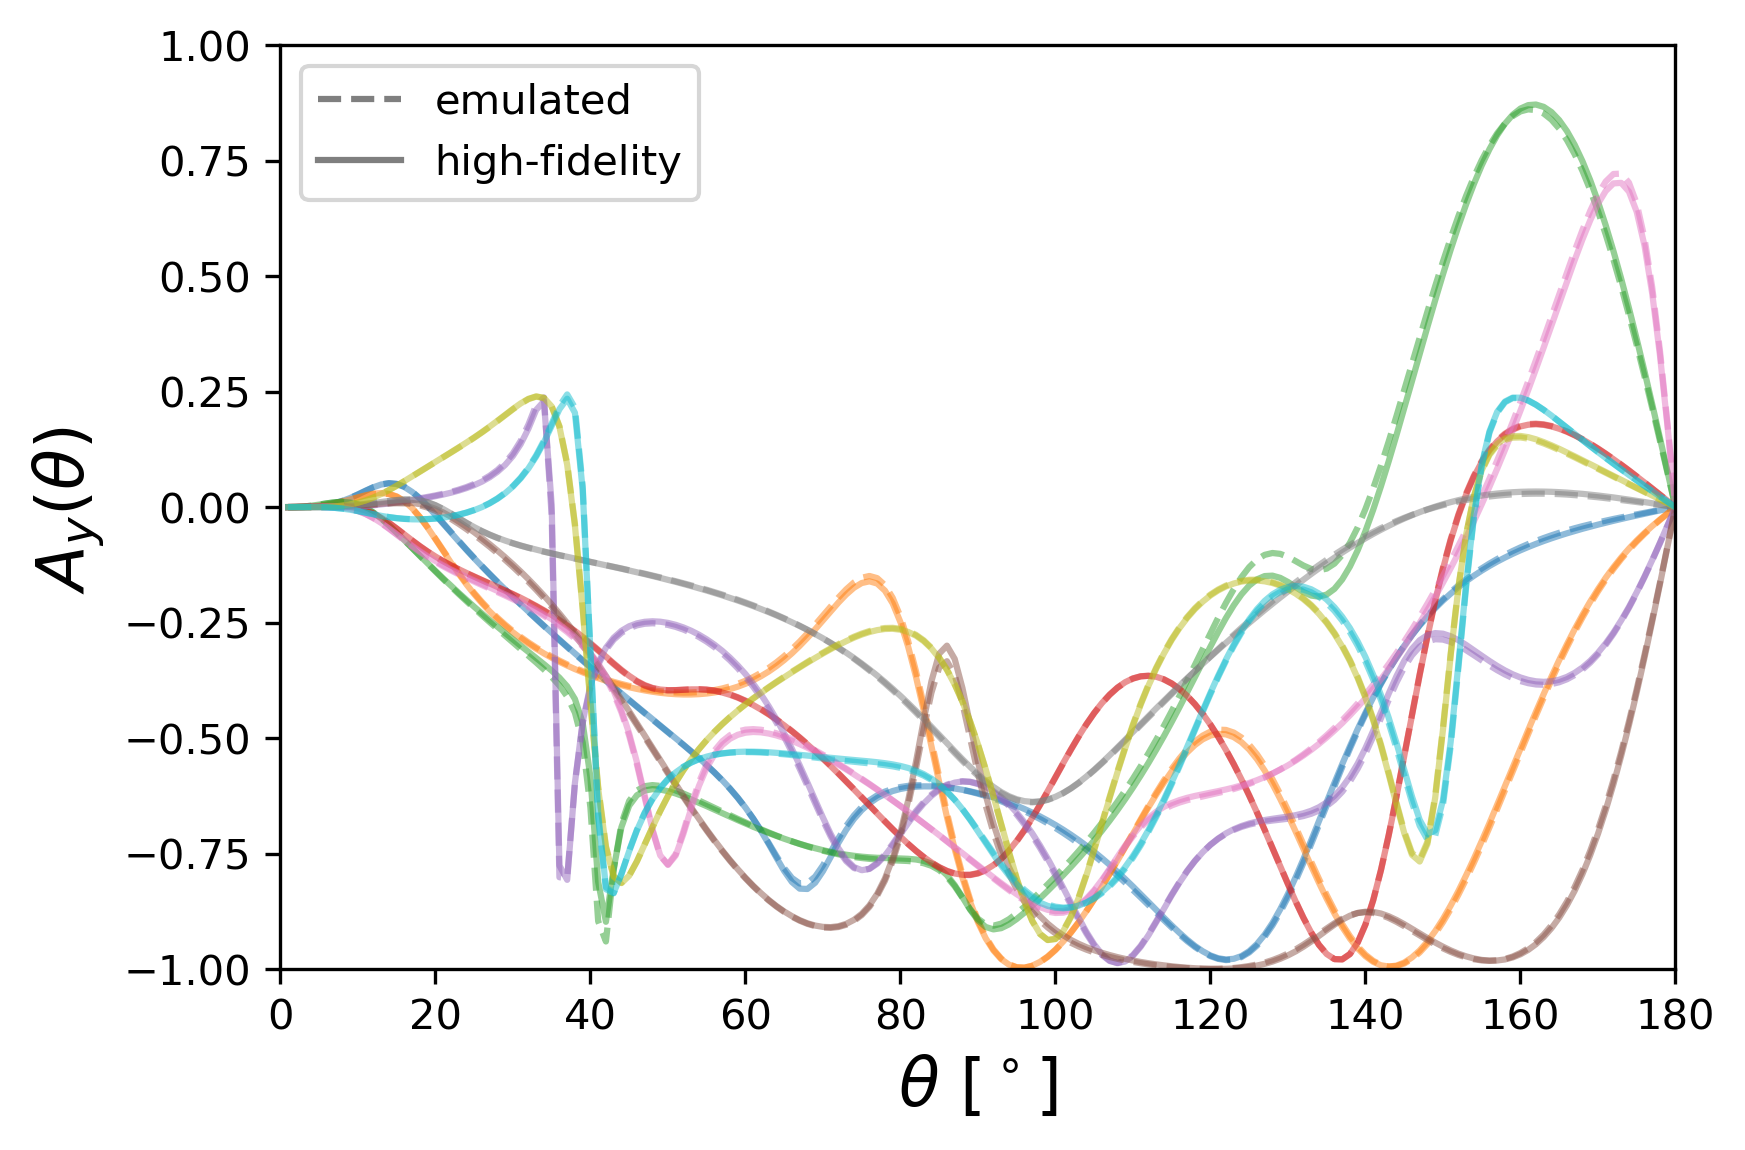

In [10]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test):
    x = emulator.angles * 180 / (np.pi)

    # HIFI
    y_exact = HIFI_xs[i].Ay

    # emulated
    y_emu = emu_xs[i].Ay

    p = ax.plot(x, y_emu, "--", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_ylim([-1, 1])
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=16)
plt.ylabel(r"$A_y(\theta)$ ", fontsize=16)
plt.show()

Isn't that nice! The following series of tutorials will walk through how to choose the the optimal hyper-parameters (like the basis size), and demonstrate linking to `surmise` for fast Bayesian uncertainty quantification!